# Инициализация

In [1]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 8.2 MB 24.5 MB/s 


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive
drive.mount('/content/drive')
import re 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, RidgeClassifier, LogisticRegressionCV, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import ExtraTreesRegressor,ExtraTreesClassifier,RandomForestClassifier,VotingClassifier,StackingRegressor,StackingClassifier,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.svm import LinearSVC,LinearSVR
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA,NMF
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split,ShuffleSplit,StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,LabelEncoder
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel,VarianceThreshold,SelectKBest,chi2
from sklearn.pipeline import TransformerMixin
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR,SVC
from sklearn.metrics import mean_absolute_error,roc_auc_score
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.multioutput import MultiOutputRegressor
from sklearn.dummy import DummyRegressor,DummyClassifier
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB,CategoricalNB,MultinomialNB
from sklearn import set_config
from scipy.special import softmax

Mounted at /content/drive


# Загрузка

In [3]:
train=pd.read_csv("/content/drive/MyDrive/Kursk/train_dataset_train.csv")
test=pd.read_csv("/content/drive/MyDrive/Kursk/test_dataset_test.csv")

In [4]:
train['text']=list(map(lambda x: re.sub(r'\<[^>]*\>', ' ', x), train['Текст Сообщения'].tolist()))
train['text2']=train['text'].str.replace('&nbsp;',' ').str.replace('\n',' ').str.strip()
train['text5']=train['text'].str.replace('&nbsp;',' ').str.replace('\n',' ')

In [5]:
test['text']=list(map(lambda x: re.sub(r'\<[^>]*\>', ' ', x), test['Текст Сообщения'].tolist()))
test['text2']=test['text'].str.replace('&nbsp;',' ').str.replace('\n',' ').str.strip()
test['text5']=test['text'].str.replace('&nbsp;',' ').str.replace('\n',' ')

In [6]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def lemmatize(text):
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return ' '.join(res)

In [7]:
train['text5_l']=list(map(lemmatize, train['text5'].tolist()))
test['text5_l']=list(map(lemmatize, test['text5'].tolist()))

In [9]:
tdic=dict(zip(train['Категория'].astype('str').groupby(train['Тематика']).describe().index.tolist(),
train['Категория'].astype('str').groupby(train['Тематика']).describe().top.tolist()))

tdic['Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования']='7'
tdic['Необходимо строительство детской (спортивной) площадки в районе частного сектора']='3'
tdic['Дорожная разметка на дорогах регионального и межмуниципального значения']='0'
tdic['Несоответствие ценника цене товара']='13'
tdic['Несправедливое распределение мест в дошкольные учреждения']='7'
tdic['Отсутствие в населённом пункте сотовой связи']='9'
tdic['Плохое материально-техническое оснащение учреждений культуры и библиотек']='3'
tdic['Очистка  от снега и наледи  дорог в микрорайонах ИЖС']='0'
tdic['Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частных лиц']='6'
tdic['Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ']='6'
tdic['Проблемы с обеспечением питанием в школах']='7'
tdic['Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения']='0'

In [10]:
test['Категория t']=list(map(lambda x: int(tdic[x]),test['Тематика'].tolist()))

# Модели

In [ ]:
train.columns

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Категория',
       'text', 'text2', 'text3', 'text4', 'text5', 'text6', 'text5_l'],
      dtype='object')

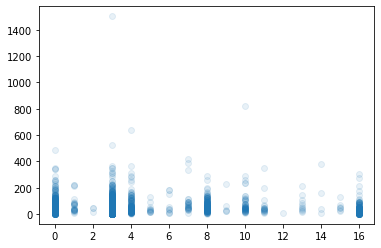

In [ ]:
plt.scatter(train['Категория'],train['text5'].str.split(' ').str.len(),alpha=0.1)

In [ ]:
est=cross_val_score(DecisionTreeClassifier(max_depth=4,class_weight='balanced'),
                    train['text5'].str.split(' ').str.len().values.reshape((len(train),1)),train['Категория'])
print(est.mean())
print(est.std())

0.047
0.012489995996796798


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [ ]:
for cnt in ['Текст Сообщения', 'text', 'text2']:
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 7),analyzer='char_wb',max_df=0.5,min_df=1),cnt),               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print(cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Текст Сообщения >>>
0.8089999999999999
0.009300537618869117


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text >>>
0.8135
0.008455767262643863


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text2 >>>
0.8135
0.009949874371066175


In [ ]:
for cnt in ['Текст Сообщения', 'text', 'text4']:
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 7),analyzer='char_wb',max_df=0.5,min_df=1),cnt),               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print(cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Текст Сообщения >>>
0.8089999999999999
0.009300537618869117


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text >>>
0.8145
0.006964194138592041


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text4 >>>
0.8140000000000001
0.009165151389911677


In [ ]:
for cnt in ['Текст Сообщения', 'text', 'text2']:
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 6),analyzer='char_wb',max_df=0.5,min_df=1),cnt),               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print(cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Текст Сообщения >>>
0.8074999999999999
0.01140175425099139


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text >>>
0.812
0.011445523142259604


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text2 >>>
0.8105
0.009924716620639606


In [ ]:
for cnt in ['Текст Сообщения', 'text', 'text2']:
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 7),analyzer='char_wb',max_df=0.5,min_df=2),cnt),               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print(cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Текст Сообщения >>>
0.805
0.007905694150420927


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text >>>
0.8125
0.009082951062292472


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text2 >>>
0.8130000000000001
0.01238951169336385


In [ ]:
for cnt in ['text', 'text2']:
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 7),analyzer='char_wb',max_df=0.5,min_df=2),cnt),               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print(cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text >>>
0.8125
0.008514693182963195


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text2 >>>
0.8135
0.01280624847486567


In [ ]:
for cnt in ['text', 'text2']:
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 8),analyzer='char_wb',max_df=0.5,min_df=2),cnt),               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print(cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text >>>
0.8150000000000001
0.00851469318296317


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text2 >>>
0.8139999999999998
0.012103718436910176


In [ ]:
for cnt in ['text', 'text2']:
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 8),analyzer='char',max_df=0.5,min_df=2),cnt),               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print(cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text >>>
0.817
0.01004987562112089


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text2 >>>
0.8150000000000001
0.009486832980505129


In [ ]:
for cnt in ['text', 'text2']:
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 8),analyzer='char',max_df=0.5,min_df=1),cnt),               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print(cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text >>>
0.8160000000000001
0.007348469228349541


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text2 >>>
0.8135
0.00815475321515004


In [ ]:
for cnt in ['text', 'text2']:
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 8),analyzer='char_wb',max_df=0.5,min_df=1),cnt),
               ('text2',CountVectorizer(ngram_range=(1, 8),analyzer='char',max_df=0.5,min_df=1),cnt)               
               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print(cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text >>>
0.8184999999999999
0.006442049363362564


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text2 >>>
0.8145
0.012389511693363853


In [ ]:
for cnt in ['Текст Сообщения','text', 'text2']:
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 2),analyzer='word',max_df=0.5,min_df=2),cnt),               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print(cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Текст Сообщения >>>
0.7769999999999999
0.019326148090087696


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text >>>
0.7885
0.023430749027719973


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text2 >>>
0.7905
0.02293468988235941


In [ ]:
for cnt in ['Текст Сообщения','text', 'text2','text5_l']:
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 1),analyzer='word',max_df=0.5,min_df=2),cnt),               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print(cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Текст Сообщения >>>
0.7895
0.024259018941416417


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text >>>
0.795
0.021679483388678804


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text2 >>>
0.7955
0.023259406699226


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text5_l >>>
0.8035
0.02332380757938119


In [ ]:
for cnt in range(1,5):
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, cnt),analyzer='word',max_df=0.5,min_df=1),'text5_l'),               
               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print('1:',cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


1: 1 >>>
0.807
0.01698528775146302


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


1: 2 >>>
0.8065
0.011467344941179696


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


1: 3 >>>
0.8
0.013601470508735456


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


1: 4 >>>
0.795
0.012942179105544783


In [ ]:
for cnt in ['text', 'text2']:
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 8),analyzer='char_wb',max_df=0.5,min_df=1),cnt),
               ('text2',CountVectorizer(ngram_range=(1, 8),analyzer='char',max_df=0.5,min_df=1),cnt),
               ('text3',CountVectorizer(ngram_range=(1, 2),analyzer='word',max_df=0.5,min_df=2),cnt)               
               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print(cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text >>>
0.8195
0.007648529270389176


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text2 >>>
0.8160000000000001
0.011247221879201968


In [ ]:
for cnt in ['text', 'text2', 'text3']:
  pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 8),analyzer='char_wb',max_df=0.5,min_df=1),cnt),
               ('text2',CountVectorizer(ngram_range=(1, 8),analyzer='char',max_df=0.5,min_df=1),cnt),
               ('text3',CountVectorizer(ngram_range=(1, 2),analyzer='word',max_df=0.5,min_df=2),cnt)               
               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
  est=cross_val_score(pipe,train,train['Категория'])
  print(cnt,'>>>')
  print(est.mean())
  print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text >>>
0.8195
0.007648529270389176


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text2 >>>
0.8160000000000001
0.011247221879201968


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


text3 >>>
0.8195
0.007648529270389176


In [ ]:
pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 8),analyzer='char_wb',max_df=0.5,min_df=1),'text'),
               ('text2',CountVectorizer(ngram_range=(1, 8),analyzer='char',max_df=0.5,min_df=1),'text'),
               ('text3',CountVectorizer(ngram_range=(1, 2),analyzer='word',max_df=0.5,min_df=1),'text5_l')               
               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
est=cross_val_score(pipe,train,train['Категория'])
print(est.mean())
print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


0.8195
0.007314369419163902


In [ ]:
pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 8),analyzer='char_wb',max_df=0.5,min_df=1),'text'),
               ('text2',CountVectorizer(ngram_range=(1, 8),analyzer='char',max_df=0.5,min_df=1),'text'),
               ('text3',CountVectorizer(ngram_range=(1, 2),analyzer='word',max_df=0.5,min_df=1),'text5_l')               
               ])),
               ('transformer',TfidfTransformer()),
               ('featureselection',SelectFromModel(LinearSVC(C=1.0,class_weight='balanced'),threshold='1*mean')),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
est=cross_val_score(pipe,train,train['Категория'])
print(est.mean())
print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


0.8184999999999999
0.009027735042633898


In [ ]:
pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 8),analyzer='char_wb',max_df=0.5,min_df=1),'text'),
               ('text2',CountVectorizer(ngram_range=(1, 8),analyzer='char',max_df=0.5,min_df=1),'text'),
               ('text3',CountVectorizer(ngram_range=(1, 2),analyzer='word',max_df=0.5,min_df=1),'text5_l')               
               ])),
               ('transformer',TfidfTransformer(norm='l1',smooth_idf=False,
                                               sublinear_tf=True)),
               ('classifier',LinearSVC(C=1.0,class_weight='balanced'))])
est=cross_val_score(pipe,train,train['Категория'])
print(est.mean())
print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


0.485
0.003162277660168382


In [ ]:
pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 8),analyzer='char_wb',max_df=0.5,min_df=1),'text'),
               ('text2',CountVectorizer(ngram_range=(1, 8),analyzer='char',max_df=0.5,min_df=1),'text'),
               ('text3',CountVectorizer(ngram_range=(1, 1),analyzer='word',max_df=0.5,min_df=1),'text5_l')               
               ])),
               ('transformer',TfidfTransformer(smooth_idf=False)),
               ('classifier',LinearSVC(C=1,class_weight='balanced'))])

In [ ]:
pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 8),analyzer='char_wb',max_df=0.5,min_df=1),'text'),
               ('text2',CountVectorizer(ngram_range=(1, 8),analyzer='char',max_df=0.5,min_df=1),'text'),
               ('text3',CountVectorizer(ngram_range=(1, 1),analyzer='word',max_df=0.5,min_df=1),'text5_l')               
               ])),
               ('transformer',TfidfTransformer(smooth_idf=False)),
               ('classifier',LinearSVC(C=1,class_weight='balanced'))])
est=cross_val_score(pipe,train,train['Категория'])
print(est.mean())
print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


0.819
0.007000000000000013


In [ ]:
pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 8),analyzer='char_wb',max_df=0.5,min_df=1),'text'),
               ('text2',CountVectorizer(ngram_range=(1, 8),analyzer='char',max_df=0.5,min_df=1),'text'),
               ])),
               ('transformer',TfidfTransformer(smooth_idf=False)),
               ('classifier',LinearSVC(C=1,class_weight='balanced'))])
est=cross_val_score(pipe,train,train['Категория'])
print(est.mean())
print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


0.8174999999999999
0.005700877125495695


In [ ]:
pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1, 8),analyzer='char_wb',max_df=0.5,min_df=1),'text'),
               ('text2',CountVectorizer(ngram_range=(1, 8),analyzer='char',max_df=0.5,min_df=1),'text'),
               ])),
               ('transformer',TfidfTransformer(smooth_idf=False)),
               ('classifier',LinearSVC(C=1,class_weight='balanced'))])
stack=StackingClassifier([('1',pipe)], final_estimator=LinearSVC(class_weight='balanced'),
                         stack_method='decision_function')
est=cross_val_score(stack,train,train['Категория'])
print(est.mean())
print(est.std())

# CV

In [12]:
from sklearn.model_selection import KFold

In [14]:
test['Категория']=test['Категория t']

In [15]:
pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1,7),analyzer='char_wb',max_df=0.3,min_df=2),'text'),
               ('text2',CountVectorizer(ngram_range=(1,1),max_df=0.3,min_df=2),'text5_l'),
               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1, class_weight='balanced'))])
test['Категория p']=0
cntt=0
for cnt in KFold(n_splits=50, random_state=1, shuffle=True).split(test):
  pipe.fit(pd.concat((train[train['Категория']!=12][['text','text5_l']],
                                    test.iloc[cnt[0]][['text','text5_l']])),
                    pd.concat((train[train['Категория']!=12]['Категория'],
                                    test['Категория'].iloc[cnt[0]])))
  
  test['Категория p'].iloc[cnt[1]]=pipe.predict(test.iloc[cnt[1]][['text','text5_l']])
  print('>>>',cntt)
  cntt+=1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 0


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 1


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 2


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 3


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 4


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 5


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 6


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 7


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 8


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 9


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 10


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 11


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 12


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 13


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 14


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 15


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 16


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 17


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 18


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 19


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 20


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 21


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 22


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 23


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 24


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 25


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 26


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 27


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 28


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 29


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 30


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 31


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 32


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 33


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 34


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 35


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 36


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 37


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 38


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 39


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 40


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 41


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 42


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 43


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 44


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 45


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 46


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 47


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


>>> 48
>>> 49


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
from sklearn.metrics import accuracy_score

In [16]:
accuracy_score(test['Категория t'], test['Категория p'])

0.851

# К отправке

In [17]:
set_config(display='diagram')

In [ ]:
pipe=Pipeline([('input',ColumnTransformer([
               ('text1',CountVectorizer(ngram_range=(1,7),analyzer='char_wb',max_df=0.3,min_df=2),'text'),
               ('text2',CountVectorizer(ngram_range=(1,1),max_df=0.3,min_df=2),'text5_l'),
               ])),
               ('transformer',TfidfTransformer()),
               ('classifier',LinearSVC(C=1, class_weight='balanced'))])
est=cross_val_score(pipe,pd.concat((train[train['Категория']!=12][['text','text5_l']],
                                    test[['text','text5_l']])),
                    pd.concat((train[train['Категория']!=12]['Категория'],
                                    test['Категория'])),cv=20)
print(est.mean())
print(est.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=20.
  UserWarning,


0.8359395973154362
0.025285085335848126


In [18]:
pipe.fit(pd.concat((train[train['Категория']!=12][['text','text5_l']],
                                    test[['text','text5_l']])),
                    pd.concat((train[train['Категория']!=12]['Категория'],
                                    test['Категория'])))

Pipeline(steps=[('input',
                 ColumnTransformer(transformers=[('text1',
                                                  CountVectorizer(analyzer='char_wb',
                                                                  max_df=0.3,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               7)),
                                                  'text'),
                                                 ('text2',
                                                  CountVectorizer(max_df=0.3,
                                                                  min_df=2),
                                                  'text5_l')])),
                ('transformer', TfidfTransformer()),
                ('classifier', LinearSVC(C=1, class_weight='balanced'))])

In [19]:
from joblib import dump, load

In [20]:
dump(pipe, '/content/drive/MyDrive/Kursk/pipe.joblib') 

['/content/drive/MyDrive/Kursk/pipe.joblib']

In [ ]:
pipe=load('/content/drive/MyDrive/Kursk/pipe1.joblib') 

In [ ]:
test['Категория']=pipe.predict(test)

In [ ]:
test['Категория']=test['Категория p']

In [ ]:
answer=test[['id','Категория']]
answer.to_csv('sample_solution.csv',index=False)
answer

,id,Категория
0,843,3
1,1422,3
2,2782,3
3,2704,3
4,1,8
...,...,...
995,2619,16
996,2518,3
997,2524,0
998,1577,4
